# Sparkify Project Workspace - Part II
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [7]:
# import libraries
from pyspark.sql import SparkSession
#from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DateType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf,count,when,isnan,regexp_replace,countDistinct,month,from_unixtime,to_timestamp,lead,datediff,mean
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import MinMaxScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [8]:
import datetime
import pyspark.sql.functions as F
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [10]:
 #load spark data
user_log = spark.read.json('mini_sparkify_event_data.json')
user_log.persist()
user_log = user_log.filter(user_log["userId"] != "")


### Churn dataset as in 'data wrangling with DataFrame'

In [11]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
user_log = user_log.withColumn("downgraded", flag_downgrade_event("page"))
# now we have for each timestamp sorted user a delta peak where the downgrade took place
from pyspark.sql import Window
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
user_log = user_log.withColumn("churn", Fsum("downgraded").over(windowval))

In [12]:
# ### As time plays a crucial role in this interaction, some derivations

# In[47]:
get_time = udf(lambda x: pd.Timestamp(x / 1000.0,unit='s').strftime("%Y-%m-%d %H:%M:%S"))
user_log = user_log.withColumn("time", get_time(user_log.ts)).withColumn('registration_time',get_time(user_log.registration))
user_log = user_log.withColumn('date', from_unixtime(col('ts')/1000).cast(DateType()))
user_log = user_log.withColumn('month', month("time").alias('month'))
user_log.head()


Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', downgraded=0, churn=0, time='2018-11-21 18:12:32', registration_time='2018-09-27 02:45:40', date=datetime.date(2018, 11, 21), month=11)

In [19]:
#The main component is churn and user, and as it shows above, that some guys 
#churn return more than 3 times, we just take the max, and do ignore the on-off details in between

churningusers = user_log.groupBy("userId").max("churn").withColumnRenamed("max(churn)", "churn")
churningusers.select(["userId", "churn"])

DataFrame[userId: string, churn: bigint]

In [20]:
#Recoding of the categorical variables....
transformgender = udf(lambda x: 1 if x == "F" else 0, IntegerType())
transformlevel =  udf(lambda x: 1 if x == "paid" else 0, IntegerType())
user_temp1 = user_log.withColumn("gender", transformgender("gender"))
user_temp2 = user_log.withColumn("level",  transformlevel ("level"))
user_temp1 = user_temp1.groupby('userId').agg({"gender": "max"}).withColumnRenamed("max(gender)", "gender")
user_temp2 = user_temp2.groupby('userId').agg({"level": "max"}).withColumnRenamed("max(level)", "level")
churningusers=churningusers.join(user_temp1, ['userId'])
churningusers=churningusers.join(user_temp2, ['userId'])


In [21]:
# Finally, join all of them together to the feature set...
# 
# In[100]:
songcount = user_log.groupby("userId").agg(countDistinct("song"))
artistdiversity = user_log.groupby("userId").agg(countDistinct("artist"))
sumoflength=user_log.groupby("userId").agg({"length" : "sum"})
visitfrequency = user_log.groupby("userId").count()
songcount = songcount.withColumnRenamed("count(DISTINCT song)", "songcount")
artistdiversity = artistdiversity.withColumnRenamed("count(DISTINCT artist)", "artistdiversity")
sumoflength=sumoflength.withColumnRenamed("sum(length)","sumoflength")
visitfrequency = visitfrequency.withColumnRenamed("count", "visitfrequency")
first_interaction =  user_log.groupBy('userId').agg(min('ts').alias('first_interaction'))
last_interaction =  user_log.groupBy('userId').agg(max('ts').alias('last_interaction'))
mean_interaction =  user_log.groupBy('userId').agg(mean('ts').alias('mean_interaction'))
# again the userid with the known churning as a test
churningusers  = churningusers.join(artistdiversity,["userId"])
churningusers  = churningusers.join(visitfrequency,["userId"])
churningusers  = churningusers.join(songcount,["userId"])
churningusers  = churningusers.join(sumoflength,["userId"])
churningusers  = churningusers.join(first_interaction,["userId"])
churningusers  = churningusers.join(last_interaction,["userId"])
churningusers  = churningusers.join(mean_interaction,["userId"])
churningusers = churningusers.withColumn('lastedinteraction', churningusers['last_interaction']-churningusers['first_interaction'])
churningusers = churningusers.withColumn('lastedinteraction', churningusers['lastedinteraction']/1e9)


In [22]:
churningusers.printSchema()
churningusers.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in churningusers.columns]).collect()

root
 |-- userId: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- artistdiversity: long (nullable = false)
 |-- visitfrequency: long (nullable = false)
 |-- songcount: long (nullable = false)
 |-- sumoflength: double (nullable = true)
 |-- first_interaction: long (nullable = true)
 |-- last_interaction: long (nullable = true)
 |-- mean_interaction: double (nullable = true)
 |-- lastedinteraction: double (nullable = true)



[Row(userId=0, churn=0, gender=0, level=0, artistdiversity=0, visitfrequency=0, songcount=0, sumoflength=0, first_interaction=0, last_interaction=0, mean_interaction=0, lastedinteraction=0)]

In [23]:
churningusers= churningusers.drop("userId")
getallfeatures = [mycol for mycol in churningusers.columns if mycol!='churn'] 
#here, userid is no longer needed, as the model is lter on served by user data, without knowlegde of origin

churningusers.printSchema()


root
 |-- churn: long (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- artistdiversity: long (nullable = false)
 |-- visitfrequency: long (nullable = false)
 |-- songcount: long (nullable = false)
 |-- sumoflength: double (nullable = true)
 |-- first_interaction: long (nullable = true)
 |-- last_interaction: long (nullable = true)
 |-- mean_interaction: double (nullable = true)
 |-- lastedinteraction: double (nullable = true)



/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


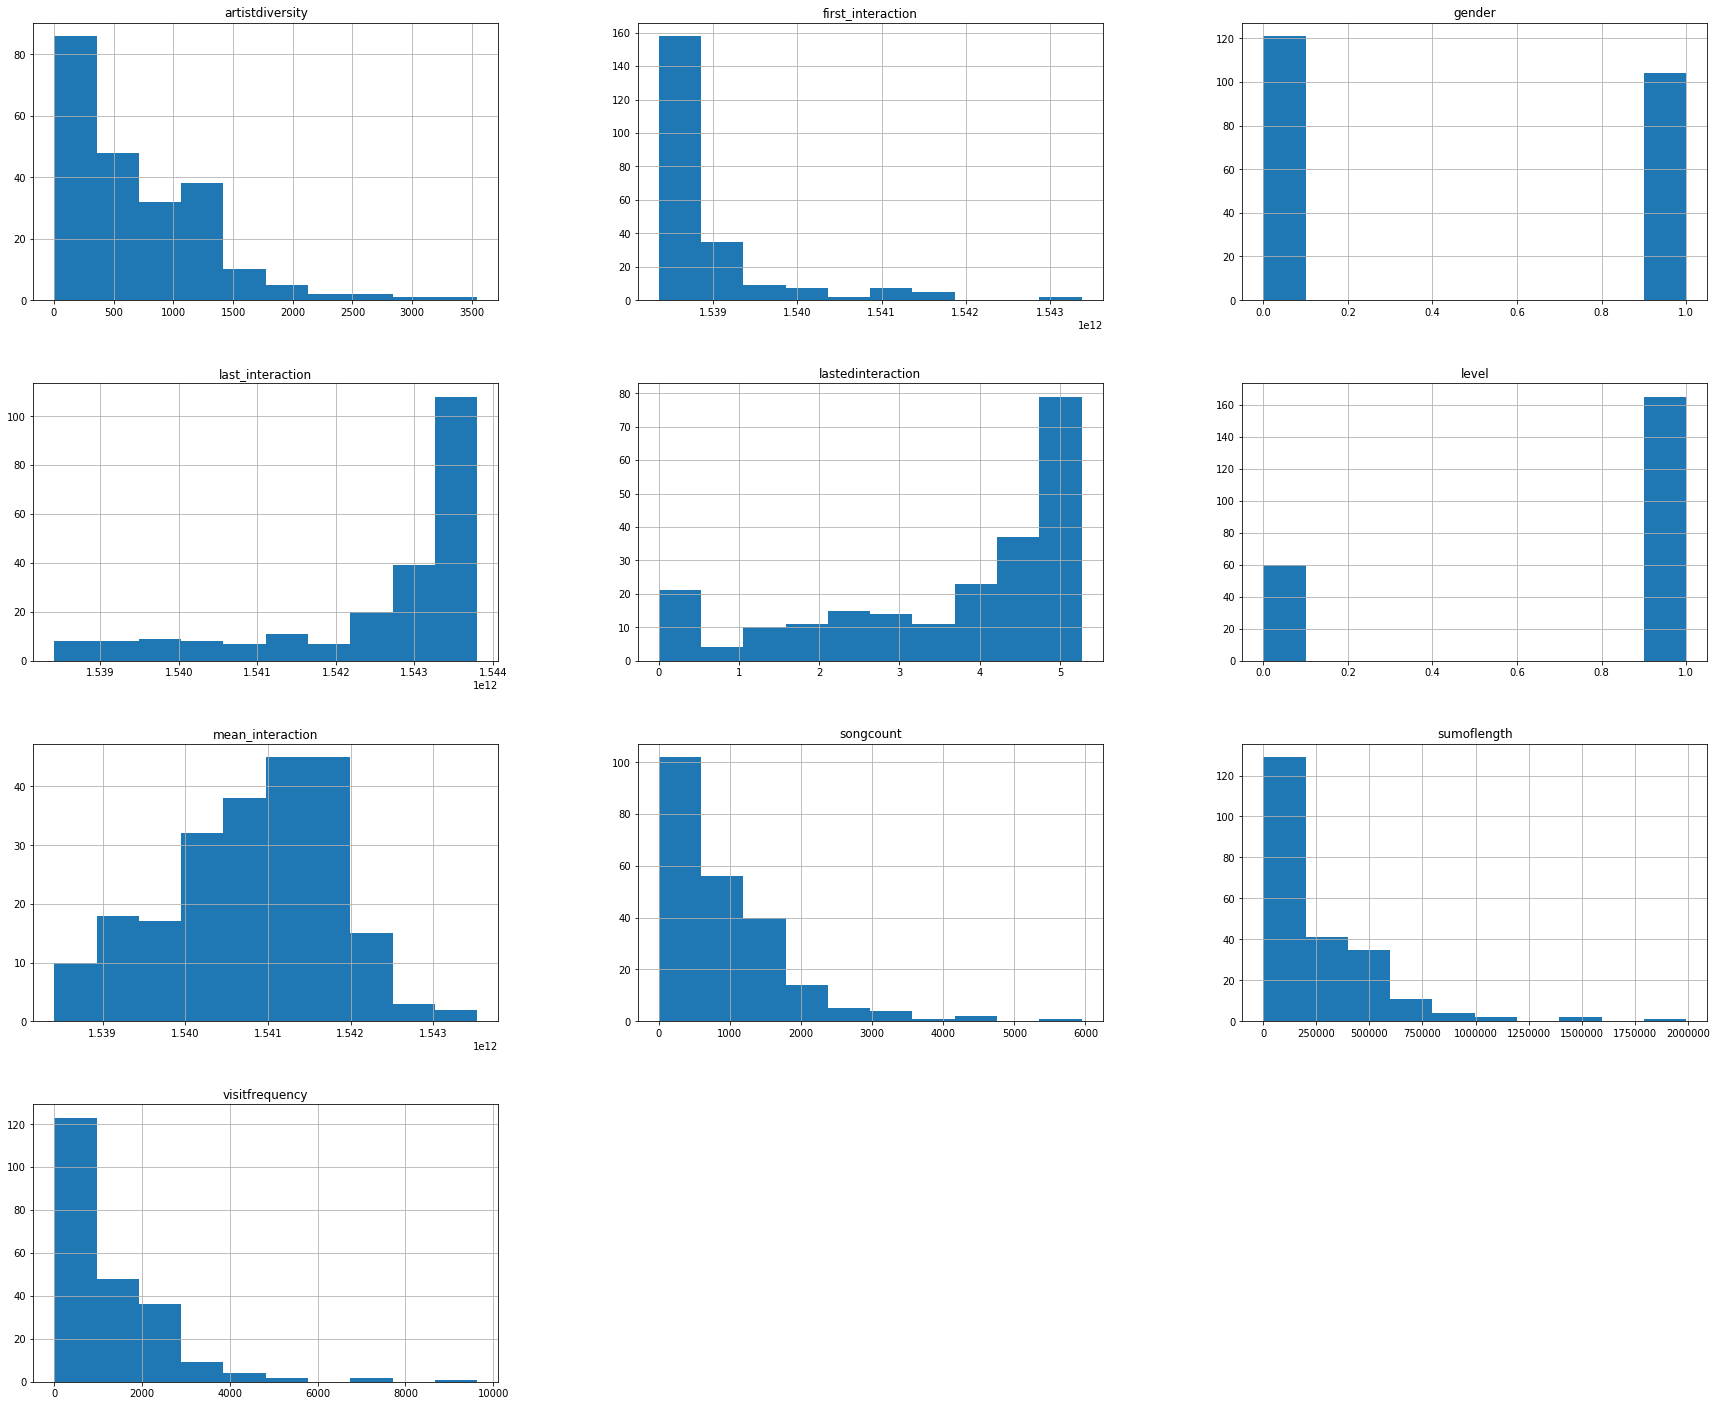

In [26]:

pandasplotfeatures = churningusers.drop("churn").toPandas()

fig = plt.figure(figsize=(30,25))
ax = fig.gca()
h = pandasplotfeatures.hist(ax=ax)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [34]:
train, test = churningusers.randomSplit([0.7, 0.3], seed=42)
train = train.cache()

def modelbuilder(myclassifier, myparam, mynumfold):
    """
    Try to setup a pipeline with given Clasifier
    Input:
    myclassifier - one type of vailable classifier classes
    param - built param grid for  model opt search
    Output :
    mymodel - ML pipeline model as transformer...
    """
    assembler = VectorAssembler(inputCols=getallfeatures, outputCol="features")
    scaler = MinMaxScaler(inputCol="features", outputCol="scfeatures")
    pipeline = Pipeline(stages=[assembler, scaler, myclassifier])
    mymodel = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=myparam,
        evaluator = \
          MulticlassClassificationEvaluator( \
          labelCol='churn', metricName='f1'),
        numFolds=mynumfold,
    )
    return mymodel


In [43]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")

In [44]:

rndf = RandomForestClassifier(featuresCol="scfeatures", labelCol="churn")
rndf_param = ParamGridBuilder().build()
rndf_model = modelbuilder(rndf, rndf_param,2)



In [45]:


rndf_fitted_model = rndf_model.fit(train)
rndf_pred = rndf_fitted_model.transform(test)

rndfscore = evaluator.evaluate(rndf_pred, {evaluator.metricName: "f1"})
print("f1 using Random Forest: {}".format(rndfscore))



f1 using Random Forest: 0.7060931899641577


In [ ]:
##here other classifier types to come

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.